Needs the `grismconf` package by Nor Pirzcal:
```bash
python -m pip install git+https://github.com/npirzkal/GRISMCONF.git
```
and the related data files:
```bash
git clone https://github.com/npirzkal/GRISM_NIRCAM.git
```

In [57]:
# %load_ext lab_black

In [58]:
import numpy as np
import pandas as pd
import astropy.io.fits as apfits
import astropy.visualization as apvis
import astropy.nddata as apndd
import astropy.table as aptable
import astropy.wcs as apwcs
import astropy.units as apunits
import astropy.coordinates as apcoords
import pandas as pd
import matplotlib.pyplot as mplplot
import matplotlib.patches as mplpatches
import glob
import os
import scipy as sp

import grismconf

In [59]:
!pwd

/Users/zx446701/Documents/Astro_Projects/Ice_Proposals/IceAge_ERS/Spectral_Extraction_Code


### Accessing Fengwu Data Files (Ex HD)

In [60]:
frameFitsDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames"
frameListDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_list"
frameSpec2dDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/extract_2d/"

#### Arrange the frames fits file list into the required format

In [61]:
# Create full list of files within folder as a list
frameFitsFiles = glob.glob(os.path.join(frameFitsDir, "*.fits")) 
# Format frameFitsFiles into a dictionary
frameFitsFiles = {
    idx: np.sort(data.to_numpy().flatten())
    for idx, data in pd.DataFrame(frameFitsFiles).groupby(
        by=pd.DataFrame(frameFitsFiles)
        .loc[:, 0]
        .apply(lambda x: "_".join(os.path.basename(x).split("_")[:3]))
    )
}

In [62]:
# To find GRISM used for observation 
with apfits.open("/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames/jw01309006001_01101_00001_nrca5_rate_wcs.fits") as test:
    print(repr(test[0].header["PUPIL"]))

'GRISMR'


#### Define functions to extract the source list, along with sky and pixel coordinates within the images

In [63]:
# Define function to extract the source list of sources within an uncalibrated image
def getSourceListForImage(image, frameListDir):
    listPath = os.path.join(
        frameListDir,
        f"{'_'.join(os.path.basename(image).split('_')[:4])}_uncal_pointsources.list",
    )
    return pd.read_csv(listPath, delim_whitespace=True, comment="#", header=None)

In [64]:
# Define function to extract the source sky coordinates of sources within an uncalibrated image
def getSourceCoordsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir) # Use previous function within this one
    coords = apcoords.SkyCoord(
        *sourceList.loc[:, [3, 4]].to_numpy().T, frame=apcoords.ICRS, unit=apunits.deg
    )
    return coords

In [65]:
# Define function to extract the source pixel coordinates of sources within an uncalibrated image
def getSourcePixelsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir)
    pixels = sourceList.loc[:, [5, 6]].to_numpy()
    return pixels

### Define Function to calculate the expected trace within the image

Code taken from https://github.com/npirzkal/GRISMCONF 

In [66]:
def computeTrace(pixels, fac=100, module="A", direction="R", simYDisp=False):
    # Locate config File for the module and grism direction 
    confFile = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V2/NIRCAM_F322W2_mod{module}_{direction}.conf"
    # Class to read and hold GRISM configuration info
    conf = grismconf.Config(confFile)
    # Found from GRISMCONF README file - see link above
    # Middle section - number of pixels from end to start in X direction
    # 1/ middle = slighting trace by number of pixels
    # /fac is for splitting by subpixel amounts
    dt = np.abs(1 / (1 + conf.DISPX("+1", *pixels, 1) - conf.DISPX("+1", *pixels, 0)) / fac)
    t = np.arange(0, 1, dt)

    # DISP(X,Y,L) = DISPERSION POLYNOMIAL (X direction, Y, Full Length)
    # order, x0, y0, steps along dispersion between 0 and 1
    # X disp polynomial
    dxs = conf.DISPX("+1", *pixels, t)
    # Y disp polynomial 
    dys = conf.DISPY("+1", *pixels, t)
    # Compute wavelength of each pixel
    wavs = conf.DISPL("+1", *pixels, t)

    return (
        pixels[0] + dxs,
        pixels[1] + dys if simYDisp else np.full_like(dys, pixels[1]),
        wavs,
    )

DO WE NEED TO ADJUST THE RETURN PER DISPERSION DIRECTION??? R AND C USING DIFFERENT DXS AND DYS?

In [67]:
def computeTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    height=50,
    # Need some guidance on what this is !
    **patchkws,
):
    confFile = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V2/NIRCAM_F322W2_mod{module}_{direction}.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace
    dxs = conf.DISPX("+1", *pixels, np.array([0, 1]))
    # Is the Y needed for this?
    dys = conf.DISPY("+1", *pixels, np.array([0, 1]))
    
    #Locating the centre of the trace 
    centrePix = conf.DISPX("+1", *pixels, np.array([0.5]))

    if returnRect:
        mplplot.scatter(pixels[0]+centrePix[0], pixels[1],c='green')
        return mplpatches.Rectangle(
            # x0,y0 in bottom left of rectangle
            (pixels[0] + dxs[0], pixels[1] - height // 2),
            # width of rectangle 
            dxs[1] - dxs[0],
            # height of box (PSF width 50 pixels)
            height,
            **patchkws,
        )
    return (pixels[0]+centrePix[0], pixels[1]), (height, abs(dxs[1] - dxs[0]))

#### Identifying the instrument sensivities for Flux calibration of spectra

In [68]:
SensFile = apfits.open(f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V2/NIRCam.F322W2.R.A.1st.sensitivity.fits")
print(repr(SensFile[1].header)) # Units check
SensTable = aptable.Table(SensFile[1].data)
SensData_WL = SensTable[0][:]
SensData_Sens = SensTable[1][:]
SensData_Er = SensData = SensTable[2][:]

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                 3541 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVELENGTH'                                                          
TFORM1  = 'D       '                                                            
TTYPE2  = 'SENSITIVITY'                                                         
TFORM2  = 'D       '                                                            
TTYPE3  = 'ERROR   '        

### Plotting the frames with source traces for all sources within the source lsit Fengwu provided

/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames/jw01309006001_01101_00001_nrca5_rate_wcs.fits Short
/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames/jw01309006001_01101_00001_nrcb5_rate_wcs.fits [ 226.064 1801.865]


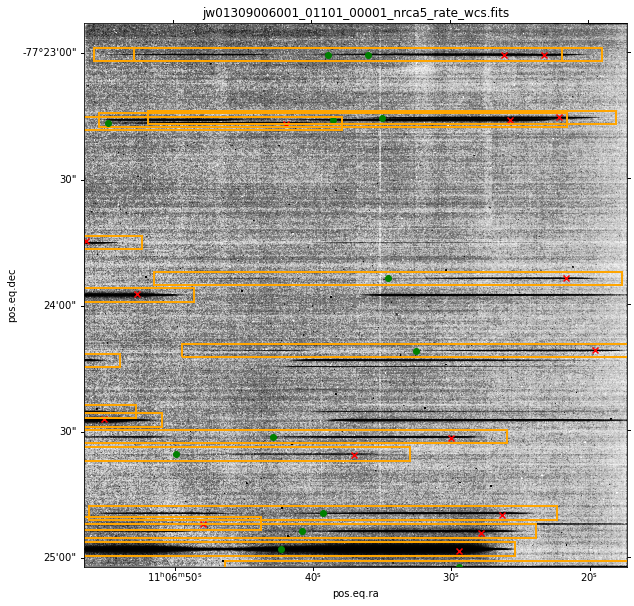

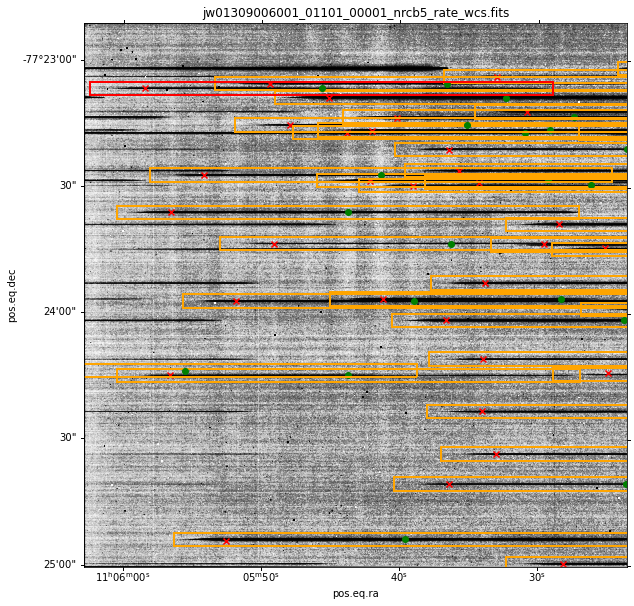

In [69]:
for imageFits in next(iter(frameFitsFiles.values())):
    with apfits.open(imageFits) as test:
        figure = mplplot.figure(figsize=(10, 10))
        ax = figure.add_subplot(1, 1, 1, projection=apwcs.WCS(test["SCI"].header))
        ax.imshow(
            # SCI is the images from the simulation
            test["SCI"].data,
            norm=apvis.ImageNormalize(
                stretch=apvis.HistEqStretch(data=test["SCI"].data),
                interval=apvis.ZScaleInterval(),
            ),
            cmap="Greys",
        )
        
        # Set image limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        # use pre-defined function to get source coordinates 
        # THE REASON WE SEE SOME TRACES WITHOUT BOXES ARE THAT THEY ARE NOT IN THE SOURCE LIST
        # CHECK BOTTOM RIGHT OF IMAGE - BOX WITH NO SOURCE
        sourceCoords = getSourceCoordsForImage(imageFits, frameListDir)
        
        # Plot sources on FOV
        ax.scatter(
            sourceCoords.ra,
            sourceCoords.dec,
            marker="x",
            c="r",
            transform=ax.get_transform("world"),
        )
        ax.set_title(os.path.basename(imageFits))
        
        # Use pre-defined function to find pixel coords of sources in image
        directPixels = getSourcePixelsForImage(imageFits, frameListDir)
        print(imageFits, directPixels[55] if len(directPixels) > 50 else "Short")
        
        # for loop to create trace boxes for each source within source list
        # HOW DO WE CHANGE FOR C DIRECTION?? NEED TO LOAD C DATA???
        # where is sourceId defined? Within imageFits???
        for sourceId, directPixel in enumerate(directPixels):
            traceBox = computeTraceBox(
                directPixel,
                module=os.path.basename(imageFits).split("_")[3][-2].upper(),
                direction="R",
                ec="red" if sourceId == 55 else "orange",
                #ec="orange",
                lw="2",
                fc="none",
            )
            ax.add_patch(traceBox)
            #print(traceBox)
        # Removing limits shows that all sources in list have traces calculated for them
        # Therefore missing traces must be due to them missing in source list which
        # will not be a problem once NIRCam Pre-imaging has been achieved
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

In [70]:
print(directPixels[55])

[ 226.064 1801.865]


### PSF models taken from WebbPSF and plotted
PSF-specific stuff starts here...

In [71]:
# Import PSF model grid modules
# Use source code to look into utils etc. - Ask Hugh how he knows when to look for these libraries!
from webbpsf.utils import to_griddedpsfmodel
from webbpsf.gridded_library import display_psf_grid

/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames/jw01309006001_01101_00001_nrcb5_rate_wcs.fits [ 226.064 1801.865]


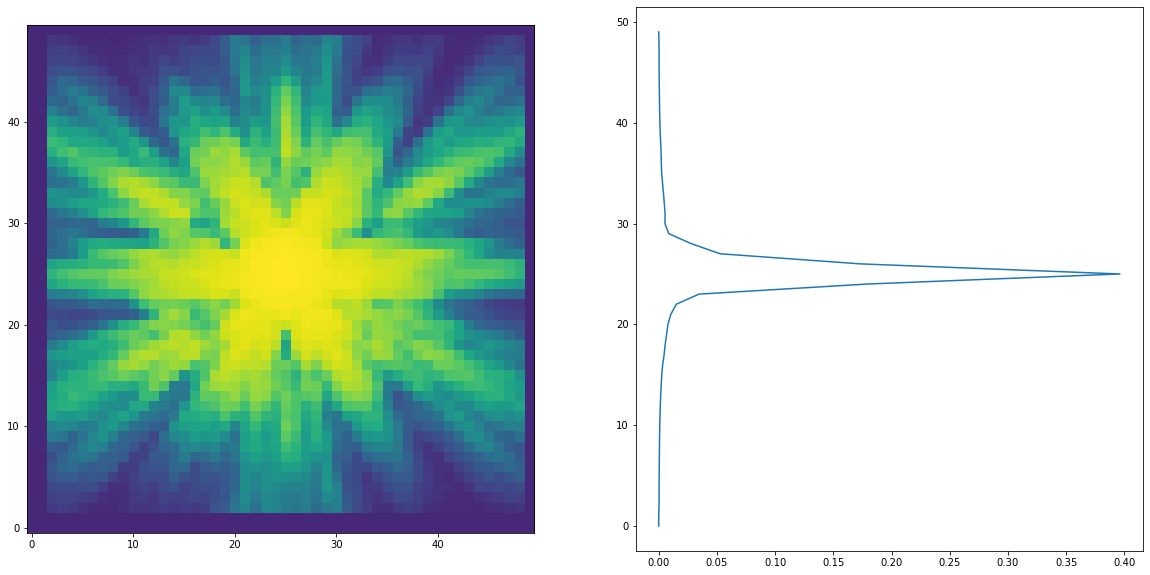

In [72]:
# How do we justify the model number (1-5??)
# Take specific instrument, module, filter and detector PSF fits files 
# and turn into a grid of how the PSF changes with position on detector array
# NUMBER OF DETECTOR IS IN NRCA5 - 5 IS LW DETECTOR 1-4 IS SW
# ONLY 5 REQUIRED FOR WFSS AS ONLY DETECTOR ABLE TO DO THIS
grid = to_griddedpsfmodel(
    "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/gridded_psf_library/nircam_nrca5_f322w2_clear_fovp47_samp5_npsf16_requirements_realization0.fits"
)
# WebbPSF way of plotting the PSF grid (4x4) on the detector array
# Also plots each grid positions difference from mean PSF 
# display_psf_grid(grid)

# Find pixel coords of target sources within the detector array of the inputted data
# using pre-defined function above.
# next() - moves onto next value of iteration
# iter() - Allows iterations of inputted data type
# pd.values() - Turns values into a numpy representation of pandas database
# [0] only works with next(iter()) 
fram_it = iter(frameFitsFiles.values())
fileName= next(fram_it)[1]
directPixels = getSourcePixelsForImage(
    fileName, frameListDir
)
print(fileName, directPixels[55])

# Setting the last pixel as directPixel (Given in an array [x,y])
directPixel = directPixels[55]

# Setting up grid for PSF to be plotted into around central pixel of source 
# The PSF is only given 25 pixels in each direction (N,E,S,W) of source pixel
# WebbPSF only models this far - any reason?
# Fits files use 4TRAN notation for grids (y,x) not C notation (x,y) hence 
# 
y,x = np.mgrid[
    int(directPixel[1] - 25) : int(directPixel[1] + 25),
    int(directPixel[0] - 25) : int(directPixel[0] + 25),
    
]

# Need to ask where .evaluate came from!! 
# Seems to create 2d PSF within given parameters around central point with a given flux
# Flux seems to be arbitrary 
# 2D array of Y axis slices divided into X axis length list
# Shape is (70,50) so 70 arrays with 50 flux values each!
psf2d = grid.evaluate(
    x=x, y=y, flux=1, x_0=int(directPixel[0]), y_0=int(directPixel[1])
)

# Plotting of 1D and 2D PSFs 
figure, (panel2d, panel1d) = mplplot.subplots(figsize=(20, 10), nrows=1, ncols=2)

# Must Normalise PSF values - purely plotting requirements
panel2d.imshow(
    psf2d,
    norm=apvis.ImageNormalize(
        stretch=apvis.HistEqStretch(data=psf2d), interval=apvis.ZScaleInterval(),
    ),
    origin="lower",
)

# Create 1D PSF along Y axis (axis=1) (or X axis=0)
# Sum all the flux values of the Y pixels in each X slice 
psf1d = psf2d.sum(axis=1)

panel1d.plot(psf1d, np.arange(psf1d.size))

In [73]:
import scipy.optimize as spopt

### Can we get ideal spectra that was inputted into sims from Fengwu to compare with our resultant spectra!

In [74]:
# Unsure where the norm parameter comes from - especially in next function
# Chi squared function to test parameters fit
def fitFunction(norm, cutoutSlice, errorSlice, psf):
    selection = errorSlice > 0
    return np.nansum(
        ((norm * psf[selection] - cutoutSlice[selection]) / errorSlice[selection]) ** 2
    )


def simplePsfMethod(cutout, error, psf, xDispRange):
    return[
        spopt.minimize(
            # parameters for function as a list in square brackets - part that varies
            # if fitting multiple sources within box, need parameters per source
            # This is the 'norm' within fitFunction
            fitFunction,
            [cutoutSlice[xDispRange].mean()],
            # Arguments - the constants 
            (cutoutSlice[xDispRange], errorSlice[xDispRange], psf[xDispRange]),
        ).x[0]
        for cutoutSlice, errorSlice in zip(cutout.T, error.T)
    ]


# def simpleCLEANMethod():
    

### This code creates a PSF fit of a single source (defined in above code - source ID 55 in red box) fitting the PSF across 25 pixels starting a 1/4 and ending 3/4's across the full PSF width 

This code needs adjusting for multiple sources within a 100 or 150 pixel height box so that any contanimation from sources within a PSF's (half)width - MEANING THE TRACEBOX FUNCTION PARAMETERS NEEDS TO CHANGE

Filename: /Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames/jw01309006001_01101_00001_nrcb5_rate_wcs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     231   ()      
  1  SCI           1 ImageHDU        49   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [18272B]   
Length of the Astropy Table = 3541
Length of the calculated trace (NON BOX)= 1743
Length of the SRF with the calculated trace x values = 1743
Length of the calculated trace (BOX)= 1743
1743


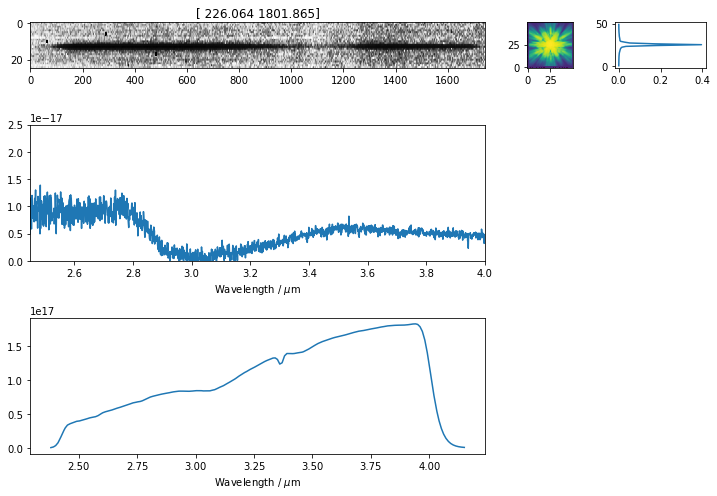

In [75]:
imageFits = next(iter(frameFitsFiles.values()))[1]
with apfits.open(imageFits) as test:

    test.info()
    # Plotting jargon
    figure, (
        (cutoutPanel, psf2dPanel, psf1dPanel),
        (extractedPanel, dummyPanel1, dummyPanel2),
        (sensPanel,dummy3, dummy4),
    ) = mplplot.subplots(
        figsize=(10, 7),
        ncols=3,
        nrows=3,
        gridspec_kw=dict(width_ratios=[5, 1, 1], height_ratios=[1, 3, 3]),
    )

    # Compute trace box of sources in selected image based on directPixel inputs
    traceBox = computeTraceBox(
        directPixel,
        module=os.path.basename(imageFits).split("_")[3][-2].upper(),
        direction="R",
        returnRect=False,
    )
    
    # Wavelength calibration step 
    trace = computeTrace(
        directPixel,
        # Fac must be set to 1 to match the number of pixels across trace
        fac=1,
        module=os.path.basename(imageFits).split("_")[3][-2].upper(),
        direction="R",
    )
    
    # Recorded ADU values of dispersion of source within  
    # trace box (of width trace length height 50 pixels for PSF) 
    # Unsure on mode = partial meaning
    cutout = apndd.Cutout2D(
        test["SCI"].data, *traceBox, mode="partial", wcs=apwcs.WCS(test["SCI"].header)
    )
    
    # Recorded ADU error values of dispersion of source within  
    # trace box (of width trace length height 50 pixels for PSF)
    errorCutout = apndd.Cutout2D(
        test["ERR"].data, *traceBox, mode="partial", wcs=apwcs.WCS(test["SCI"].header)
    )
    
    # Recorded flags of dispersion of source within  
    # trace box (of width trace length height 50 pixels for PSF)
#     dqCutout = apndd.Cutout2D(
#         test["DQ"].data, *traceBox, mode="partial", wcs=apwcs.WCS(test["SCI"].header)
#     )
    
    # Cutout from Simulation plot
    cutoutPanel.imshow(
        cutout.data[slice(psf1d.size // 4, 3 * psf1d.size // 4)],
        aspect="auto",
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=cutout.data),
            interval=apvis.ZScaleInterval(),
        ),
        cmap="Greys",
    )
    cutoutPanel.set_title(f"{directPixel}")
    
    # 2D PSF plot
    psf2dPanel.imshow(
        psf2d,
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=psf2d), interval=apvis.ZScaleInterval()
        ),
        origin="lower",
    )
    
    # 1D PSF plot
    psf1dPanel.plot(psf1d, np.arange(psf1d.size))
    
    # norm is the cutout.data (data that varies - our parameters)
    # Why are we only including 50% of slice height?
    extracted = simplePsfMethod(
        cutout.data,
        errorCutout.data,
        psf1d,
        xDispRange=slice(psf1d.size // 4, 3 * psf1d.size // 4),
    )
    
   
    # Set up the Spectral Response Function Curve to perform Flux calibration (from ADU to Flux)
    SRFCurve = sp.interpolate.interp1d(SensData_WL,SensData_Sens,kind='cubic')
    
    print("Length of the Astropy Table =", len(SensData_Sens))
    
    test_SRF = SRFCurve(trace[2])
    print("Length of the calculated trace (NON BOX)=", len(trace[2]))
    print("Length of the SRF with the calculated trace x values =", len(test_SRF))
    
#     extractedPanel.plot(table[0][:],table[1][:])
#     extractedPanel.plot(trace[2],test_SRF,ls='--')
    
    print("Length of the calculated trace (BOX)=", len(extracted))
#     data_SRF = SRFCurve(extracted)
#     print(len(extracted))
#     print(len(dataSRF))
    
    calibratedFlux = extracted[::-1]/test_SRF
    print(len(calibratedFlux))
    
    # Extracted Spectra plot following pixel numbers of traces (not wavelength corrected yet)

    extractedPanel.plot(trace[2],calibratedFlux)
    extractedPanel.set_xlim(2.45,4.0)
    extractedPanel.set_xlabel("Wavelength / $\mu$m")
    extractedPanel.set_ylim(0,0.25e-16)
    
#     extractedPanel.set_xlim(*cutoutPanel.get_xlim())
    
    # Empty plots
    dummyPanel1.axis("off")
    dummyPanel2.axis("off")

    #Throughput plot of NIRCam 
    sensPanel.plot(SensData_WL,SensData_Sens)
    sensPanel.set_xlabel("Wavelength / $\mu$m")
    
    dummy3.axis("off")
    dummy4.axis("off")
    # 
#     errors = np.flatnonzero(np.array(extracted) > 2)
#     for error in errors:
#         mplplot.figure()
#         mplplot.plot(cutout.data.T[error, slice(psf1d.size // 4, 3 * psf1d.size // 4)])
#         mplplot.plot(
#             psf1d[slice(psf1d.size // 4, 3 * psf1d.size // 4)] * extracted[error]
#         )

mplplot.tight_layout()

What do I need to convert this to wavelength?


Text(0, 0.5, 'Vertical Pixel Number')

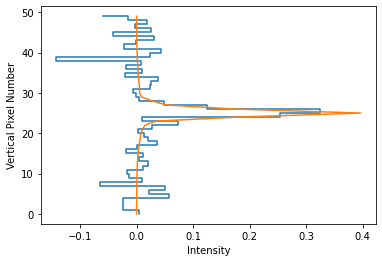

In [95]:
mplplot.step(cutout.data.T[400],np.arange(cutout.data.T[100].size))
mplplot.plot(psf1d, np.arange(psf1d.size))
mplplot.xlabel("Intensity")
mplplot.ylabel("Vertical Pixel Number")

In [20]:
print(len(trace[2]))
print(type(extracted))

1743
<class 'list'>


In [21]:
print(trace[2])
print(traceBox)

[2.38999848 2.39100305 2.39200763 ... 4.13796303 4.13896761 4.13997218]
((895.3867090000002, 1801.865), (50, 1743.0278879999987))
